In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.optimize import root

c = 11.2 #KPa
alpha1 = 0.0499
alpha2 = 1.0672
alpha3 = 0.4775
alpha4 = 0.0042
alpha5 = 0.0903
alpha6 = 0.0585
a0 = 2.0 #mm
b0 = 3.0 #mm
G_z = 1.0
num_points = 100

In [2]:
def calc_residual_stress(G_r, G_tetta, G_z, num_points):
    def J_G(R):
        return G_r * G_tetta * G_z

    def r_func(R, a, lam):
        integral = quad(lambda x: J_G(x) * x, a0, R)[0]
        return np.sqrt(a**2 + (2/lam) * integral)

    def lambda_r_star(R, a, lam):
        h = 1e-6
        r_plus = r_func(R + h, a, lam)
        r_minus = r_func(R - h, a, lam)
        dr_dR = (r_plus - r_minus) / (2*h)
        return dr_dR / G_r

    def lambda_tetta_star(R, a, lam):
        r_val = r_func(R, a, lam)
        return r_val / (R * G_tetta)

    def lambda_z_star(R, a, lam):
        return lam / G_z

    def Q(E_r, E_tetta, E_z):
        return (alpha1*E_r**2 + alpha2*E_tetta**2 + alpha3*E_z**2 +
                2*alpha4*E_r*E_tetta + 2*alpha5*E_tetta*E_z +
                2*alpha6*E_z*E_r)

    def sigma_r_hat(R, a, lam):
        lr = lambda_r_star(R, a, lam)
        E_r = (lr**2 - 1)/2
        ltetta = lambda_tetta_star(R, a, lam)
        E_tetta = (ltetta**2 - 1)/2
        lz = lambda_z_star(R, a, lam)
        E_z = (lz**2 - 1)/2

        dQ_dEr = 2*alpha1*E_r + 2*alpha4*E_tetta + 2*alpha6*E_z
        return lr**2 * c * np.exp(Q(E_r, E_tetta, E_z)) * dQ_dEr

    def sigma_tetta_hat(R, a, lam):
        lr = lambda_r_star(R, a, lam)
        E_r = (lr**2 - 1)/2
        ltetta = lambda_tetta_star(R, a, lam)
        E_tetta = (ltetta**2 - 1)/2
        lz = lambda_z_star(R, a, lam)
        E_z = (lz**2 - 1)/2

        dQ_dEtetta = 2*alpha2*E_tetta + 2*alpha4*E_r + 2*alpha5*E_z
        return ltetta**2 * c * np.exp(Q(E_r, E_tetta, E_z)) * dQ_dEtetta

    def sigma_z_hat(R, a, lam):
        lr = lambda_r_star(R, a, lam)
        E_r = (lr**2 - 1)/2
        ltetta = lambda_tetta_star(R, a, lam)
        E_tetta = (ltetta**2 - 1)/2
        lz = lambda_z_star(R, a, lam)
        E_z = (lz**2 - 1)/2

        dQ_dEz = 2*alpha3*E_z + 2*alpha5*E_tetta + 2*alpha6*E_r
        return lz**2 * c * np.exp(Q(E_r, E_tetta, E_z)) * dQ_dEz

    def equation1(a_lam):
        a, lam = a_lam
        def integrand(R):
            sigma_r = sigma_r_hat(R, a, lam)
            sigma_tetta = sigma_tetta_hat(R, a, lam)
            r_val = r_func(R, a, lam)
            return (sigma_tetta - sigma_r)/r_val
        integral, _ = quad(integrand, a0, b0)
        return integral

    def equation2(a_lam):
        a, lam = a_lam
        def integrand(R):
            sigma_r = sigma_r_hat(R, a, lam)
            sigma_theta = sigma_tetta_hat(R, a, lam)
            sigma_z = sigma_z_hat(R, a, lam)
            r_val = r_func(R, a, lam)
            return (2*sigma_z - sigma_r - sigma_theta)*r_val
        integral, _ = quad(integrand, a0, b0)
        return integral

    def equations(a_lam):
        return [equation1(a_lam), equation2(a_lam)]
    
    initial_guess = [a0, 1.0]
    solution = root(equations, initial_guess)
    if not solution.success:
        print(f"Solution not found for Gr={G_r}, Gtheta={G_tetta}")
        return None, None

    a_sol, lam_sol = solution.x

    R_points = np.linspace(a0, b0, num_points)
    r_points = np.array([r_func(R, a_sol, lam_sol) for R in R_points])

    sigma_tetta_points = np.zeros(num_points)

    for i, R in enumerate(R_points):
        r_val = r_points[i]
        sigma_r_hat_val = sigma_r_hat(R, a_sol, lam_sol)
        sigma_tetta_hat_val = sigma_tetta_hat(R, a_sol, lam_sol)

        def integrand(r_prime):
            idx = np.searchsorted(r_points, r_prime)
            if idx == 0 or idx >= len(R_points):
                return 0
            R1 = R_points[idx-1]
            R2 = R_points[idx]
            r1 = r_points[idx-1]
            r2 = r_points[idx]
            R_prime = R1 + (R2-R1)*(r_prime-r1)/(r2-r1)

            sigma_r_hat_prime = sigma_r_hat(R_prime, a_sol, lam_sol)
            sigma_theta_hat_prime = sigma_tetta_hat(R_prime, a_sol, lam_sol)
            return (sigma_theta_hat_prime - sigma_r_hat_prime)/r_prime

        integral, _ = quad(integrand, a_sol, r_val)
        p = sigma_r_hat_val + integral
        sigma_tetta_points[i] = sigma_tetta_hat_val - p

    return r_points, sigma_tetta_points

C:\Users\Карина\AppData\Local\Temp\ipykernel_14620\2949745973.py:117: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  integral, _ = quad(integrand, a_sol, r_val)
C:\Users\Карина\AppData\Local\Temp\ipykernel_14620\2949745973.py:117: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  integral, _ = quad(integrand, a_sol, r_val)


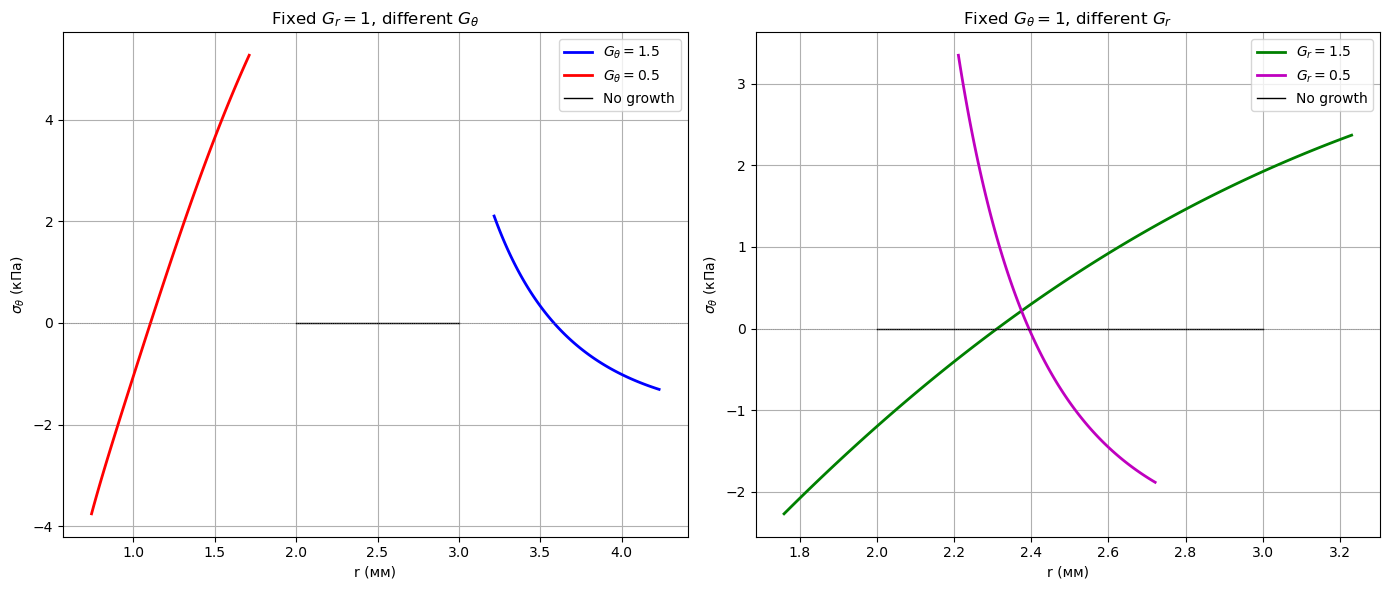

In [3]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
r1, sigma_tetta1 = calc_residual_stress(1.0, 1.5, G_z, num_points)
plt.plot(r1, sigma_tetta1, 'b-', linewidth=2, label='$G_θ=1.5$')
r2, sigma_tetta2 = calc_residual_stress(1.0, 0.5, G_z, num_points)
plt.plot(r2, sigma_tetta2, 'r-', linewidth=2, label='$G_θ=0.5$')
r3, sigma_tetta3 = calc_residual_stress(1.0, 1.0, G_z, num_points)
plt.plot(r3, sigma_tetta3, 'k-', linewidth=1, label='No growth')
plt.title('Fixed $G_r=1$, different $G_θ$', fontsize=12)
plt.xlabel('r (мм)', fontsize=10)
plt.ylabel('$σ_θ$ (кПа)', fontsize=10)
plt.grid(True)
plt.legend()
plt.axhline(0, color='gray', linestyle=':', linewidth=0.5)

plt.subplot(1, 2, 2)
r4, sigma_tetta4 = calc_residual_stress(1.5, 1.0, G_z, num_points)
plt.plot(r4, sigma_tetta4, 'g-', linewidth=2, label='$G_r=1.5$')
r5, sigma_tetta5 = calc_residual_stress(0.5, 1.0, G_z, num_points)
plt.plot(r5, sigma_tetta5, 'm-', linewidth=2, label='$G_r=0.5$')
r6, sigma_tetta6 = calc_residual_stress(1.0, 1.0, G_z, num_points)
plt.plot(r6, sigma_tetta6, 'k-', linewidth=1, label='No growth')
plt.title('Fixed $G_θ=1$, different $G_r$', fontsize=12)
plt.xlabel('r (мм)', fontsize=10)
plt.ylabel('$σ_θ$ (кПа)', fontsize=10)
plt.grid(True)
plt.legend()
plt.axhline(0, color='gray', linestyle=':', linewidth=0.5)
plt.tight_layout()
plt.show()